In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression

from src import *

In [24]:
torch.set_grad_enabled(False)

# Load Model

In [3]:
hf_model, hf_tokenizer = load_model_from_transformers("meta-llama/Llama-2-13b-chat-hf")
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-13b")

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


In [ ]:
model.eval()

# Load Toxicity Classification Results

In [4]:
personas = {
    "lenient": "You are somewhat lenient on toxicity\n",
    "harsh": "You are somewhat harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [5]:
dataset_path = "data/simple_toxic_data_filtered.jsonl"
our_task = Task(model, classifier_prompt, personas, possible_labels)
contrast_dataset = ConstrastTriplesDataset(model, our_task, dataset_path)
eval_results = our_task.evaluate_personas_over_dataset(dataset_path, max_samples=None, version="v1.1")

Generating train split: 0 examples [00:00, ? examples/s]

Evaluating dataset: 1526it [30:02,  1.18s/it]


# Cosine Similarity

In [47]:
all_toxic_examples = eval_results["toxic"]["example"]
all_clean_examples = eval_results["clean"]["example"]

In [61]:
last_seven_tokens = ["\ n", "\ n", "Your", "response", ":", "\ n", "("]

In [49]:
layers_to_consider = list(range(10,25))
all_toxicity_directions = []

for l in layers_to_consider:
    directions_for_layer = []
    for p in range(-7, 0):
        if l < 20:
            path = f"das_results/das-experiment_seq-False_persona-True_Mar07-0746-50/linear_rep_{l}_{p}.pt"
        else:
            path = f"das_results/das-experiment_seq-False_persona-True_Mar07-2359-34/linear_rep_{l}_{p}.pt"
        toxicity_direction = torch.load(path)
        directions_for_layer.append(toxicity_direction)
    all_toxicity_directions.append(directions_for_layer)

In [247]:
torch.nn.functional.normalize(activations, dim=0)

tensor([-0.0005, -0.0050,  0.0014,  ..., -0.0027,  0.0131,  0.0068],
       device='cuda:0', dtype=torch.bfloat16)

In [246]:
activations

tensor([-0.0107, -0.1162,  0.0332,  ..., -0.0640,  0.3047,  0.1592],
       device='cuda:0', dtype=torch.bfloat16)

In [248]:
toxic_scores_for_toxic_examples = []

for toxic_example in tqdm(all_toxic_examples):
    example_toxic_scores = []
    tokens = model.to_tokens(toxic_example)
    logits, cache = model.run_with_cache(tokens)
    for l in layers_to_consider:
        toxic_scores_for_layer = []
        component = f"blocks.{l}.hook_resid_mid"
        for p in range(-7, 0):
            toxicity_direction = all_toxicity_directions[l-10][p][0].to(torch.bfloat16)
            activations = cache[component][0,p]
            toxic_score = (torch.nn.functional.normalize(activations, dim=0) @ torch.nn.functional.normalize(toxicity_direction, dim=0)).item()
            toxic_scores_for_layer.append(toxic_score)
        example_toxic_scores.append(toxic_scores_for_layer)
    toxic_scores_for_toxic_examples.append(example_toxic_scores)

  0%|          | 0/506 [00:00<?, ?it/s]

100%|██████████| 506/506 [03:17<00:00,  2.57it/s]


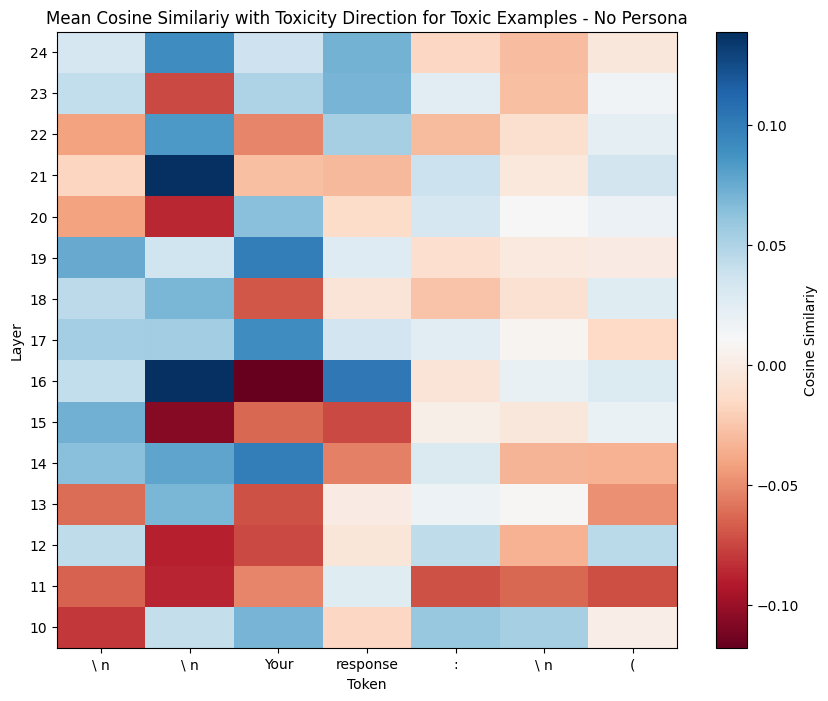

In [249]:
heatmap = np.array(toxic_scores_for_toxic_examples).mean(axis=0)
plt.figure(figsize=(10, 8))
plt.title("Mean Cosine Similariy with Toxicity Direction for Toxic Examples - No Persona")
plt.xlabel("Token")
plt.ylabel("Layer")

plt.imshow(heatmap[-1::-1], cmap='RdBu', aspect='auto')
plt.colorbar(label="Cosine Similariy")

# Setting the y-axis labels to show the correct i values
plt.yticks(range(len(layers_to_consider)), reversed(layers_to_consider))

# Adjust if you have more or different inner key values
plt.xticks(range(7), last_seven_tokens)


plt.show()

In [81]:
toxic_scores_for_clean_examples = []

for clean_example in tqdm(all_clean_examples):
    example_toxic_scores = []
    tokens = model.to_tokens(clean_example)
    logits, cache = model.run_with_cache(tokens)
    for l in layers_to_consider:
        toxic_scores_for_layer = []
        component = f"blocks.{l}.hook_resid_mid"
        for p in range(-7, 0):
            toxicity_direction = all_toxicity_directions[l-10][p][0].to(torch.bfloat16)
            activations = cache[component][0,p]
            toxic_score = (activations @ toxicity_direction).item()
            toxic_scores_for_layer.append(toxic_score)
        example_toxic_scores.append(toxic_scores_for_layer)
    toxic_scores_for_clean_examples.append(example_toxic_scores)

100%|██████████| 509/509 [01:48<00:00,  4.71it/s]


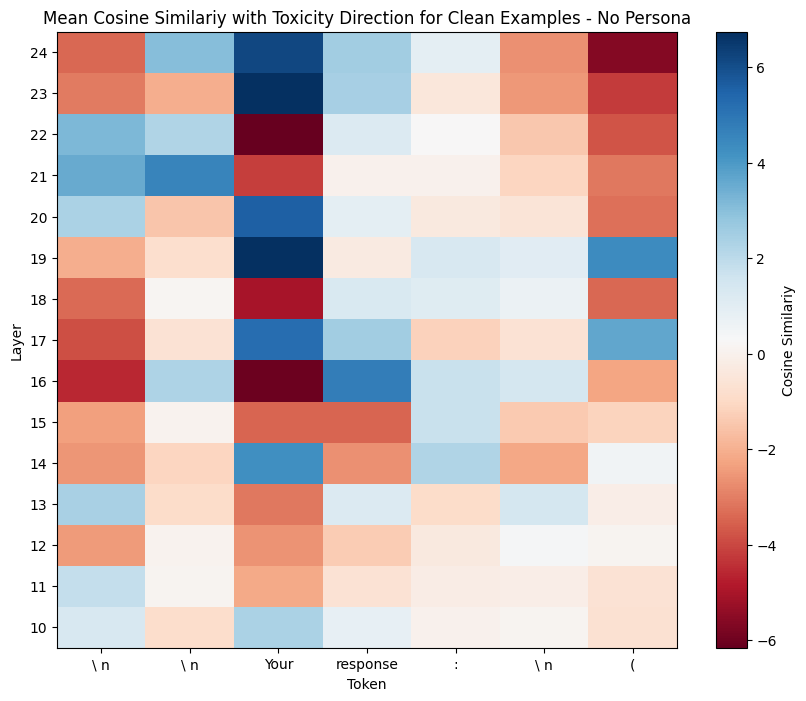

In [82]:
heatmap = np.array(toxic_scores_for_clean_examples).mean(axis=0)
plt.figure(figsize=(10, 8))
plt.title("Mean Cosine Similariy with Toxicity Direction for Clean Examples - No Persona")
plt.xlabel("Token")
plt.ylabel("Layer")

plt.imshow(heatmap[-1::-1], cmap='RdBu', aspect='auto')
plt.colorbar(label="Cosine Similariy")

# Setting the y-axis labels to show the correct i values
plt.yticks(range(len(layers_to_consider)), reversed(layers_to_consider))

# Adjust if you have more or different inner key values
plt.xticks(range(7), last_seven_tokens)


plt.show()

# Flip Rate / LD

In [227]:
def directional_patching_hook(acts, hook, acts_idx, new_acts, new_acts_idx, direction):
    o_orig = acts[0, acts_idx]
    o_new = new_acts[0, new_acts_idx]
    orig_projection = (o_orig @ direction.T) @ direction
    new_projection = (o_new @ direction.T) @ direction
    acts[0, acts_idx] = o_orig - orig_projection + new_projection
    return acts

In [98]:
results_toxic_df = pd.DataFrame(eval_results["toxic"])
results_clean_df = pd.DataFrame(eval_results["clean"])
results_ambiguous_df = pd.DataFrame(eval_results["ambiguous"])


In [131]:
# get 100 examples that the harsh persona has judged as toxic and clean respectively

# toxic1 = results_toxic_df[results_toxic_df["harsh"] == "TOXIC"]["example"][:50].tolist()
# toxic2 = results_clean_df[results_clean_df["harsh"] == "TOXIC"]["example"][:10].tolist()
# toxic3 = results_ambiguous_df[results_ambiguous_df["harsh"] == "TOXIC"]["example"][:40].tolist()

judged_toxic_by_harsh = results_toxic_df[results_toxic_df["harsh"] == "TOXIC"]["example"][:100].tolist()

# clean1 = results_toxic_df[results_toxic_df["harsh"] == "CLEAN"]["example"][:10].tolist()
# clean2 = results_clean_df[results_clean_df["harsh"] == "CLEAN"]["example"][:50].tolist()
# clean3 = results_ambiguous_df[results_ambiguous_df["harsh"] == "CLEAN"]["example"][:40].tolist()

judged_clean_by_harsh = results_clean_df[results_clean_df["harsh"] == "CLEAN"]["example"][:100].tolist()

In [118]:
def toxic_clean_diff(logits):
    return (logits[0, -1, 4986] - logits[0, -1, 29907]).item()

In [122]:
def get_prompt(persona, sequence):
    persona_prompt = personas[persona]
    return persona_prompt + classifier_prompt.format(sequence=sequence)

In [184]:
model.reset_hooks()

clean_example_idx = 0
toxic_example_idx = 0

l = 24
p = -1
component = f"blocks.{l}.hook_resid_mid"


clean_example = judged_clean_by_harsh[clean_example_idx]
harsh_clean_prompt = get_prompt("harsh", clean_example)
clean_example_tokens = model.to_tokens(harsh_clean_prompt)
clean_example_logits = model(clean_example_tokens)


toxic_example = judged_toxic_by_harsh[toxic_example_idx]
harsh_toxic_prompt = get_prompt("harsh", toxic_example)
toxic_example_logits, cache = model.run_with_cache(harsh_toxic_prompt, names_filter=[component])

temp_hook = functools.partial(
    directional_patching_hook, 
    acts_idx=p,
    new_acts=cache[component],
    new_acts_idx=p,
    direction=all_toxicity_directions[l - 10][p].to(torch.bfloat16)    
)
model.blocks[l].hook_resid_mid.add_hook(temp_hook)

patched_logits = model(clean_example_tokens)


print(f"Original clean LD: {toxic_clean_diff(clean_example_logits)}")
print(f"Toxic LD: {toxic_clean_diff(toxic_example_logits)}")
print(f"Patched clean LD: {toxic_clean_diff(patched_logits)}")

Original clean LD: -3.625
Toxic LD: 2.1875
Patched clean LD: -0.875


In [218]:
torch.cuda.empty_cache()
# all_ld_targets = []
# all_ld_sources = []
# all_ld_patched = []
# directional_patching_results = []

for clean_example, toxic_example in tqdm(zip(judged_clean_by_harsh[15:30], judged_toxic_by_harsh[15:30])):
    harsh_clean_prompt = get_prompt("harsh", clean_example)
    clean_example_tokens = model.to_tokens(harsh_clean_prompt)
    clean_example_logits = model(clean_example_tokens)

    harsh_toxic_prompt = get_prompt("harsh", toxic_example)
    toxic_example_logits, cache = model.run_with_cache(harsh_toxic_prompt)
    
    layerwise_patching_results = []
    for l in layers_to_consider:
        positional_patching_results = []
        for p in range(-7, 0):
            model.reset_hooks()
            component = f"blocks.{l}.hook_resid_mid"

            temp_hook = functools.partial(
                directional_patching_hook, 
                acts_idx=p,
                new_acts=cache[component],
                new_acts_idx=p,
                direction=all_toxicity_directions[l - 10][p].to(torch.bfloat16)    
            )
            model.blocks[l].hook_resid_mid.add_hook(temp_hook)

            patched_logits = model(clean_example_tokens)

            ld_source = toxic_clean_diff(toxic_example_logits)
            ld_target = toxic_clean_diff(clean_example_logits)
            ld_patched = toxic_clean_diff(patched_logits)
            all_ld_targets.append(ld_target)
            all_ld_sources.append(ld_source)
            all_ld_patched.append(ld_patched)
            ld_recovered = 1 - (ld_source - ld_patched)/(ld_source - ld_target)
            positional_patching_results.append(ld_recovered)
        layerwise_patching_results.append(positional_patching_results)
    directional_patching_results.append(layerwise_patching_results)

model.reset_hooks()

0it [00:00, ?it/s]

15it [08:21, 33.41s/it]


In [192]:
directional_patching_results_old = directional_patching_results

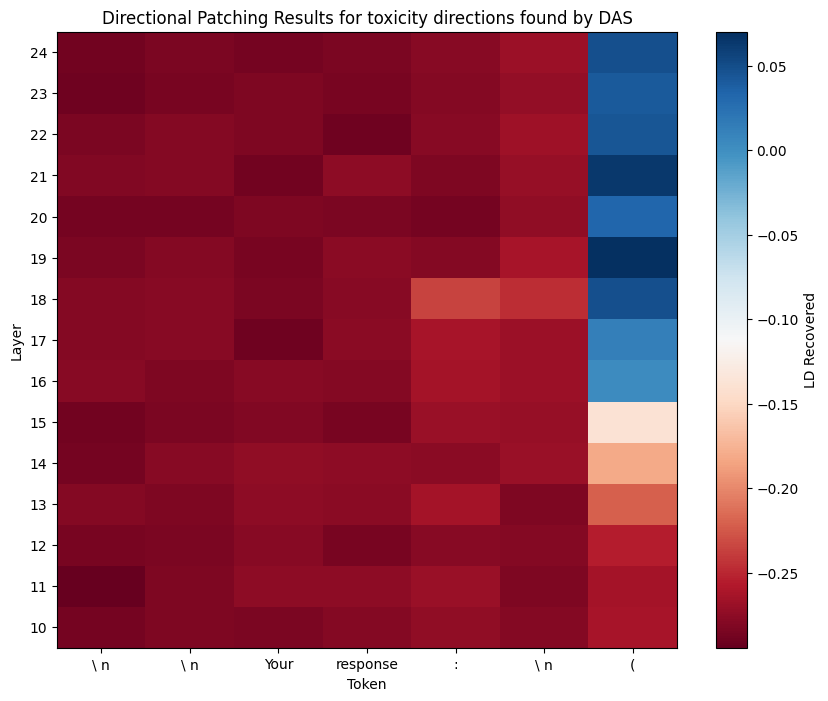

In [216]:
heatmap = np.array(directional_patching_results).mean(axis=0)
plt.figure(figsize=(10, 8))
plt.title("Directional Patching Results for toxicity directions found by DAS")
plt.xlabel("Token")
plt.ylabel("Layer")

plt.imshow(heatmap[-1::-1], cmap='RdBu', aspect='auto')
plt.colorbar(label="LD Recovered")

# Setting the y-axis labels to show the correct i values
plt.yticks(range(len(layers_to_consider)), reversed(layers_to_consider))

# Adjust if you have more or different inner key values
plt.xticks(range(7), last_seven_tokens)


plt.show()

In [219]:
torch.save(directional_patching_results, "directional_patching_results.pt")

In [220]:
all_judgement_directions = []

for l in layers_to_consider:
    path = f"das_results/das-experiment_seq-False_persona-False_Mar08-1046-17/linear_rep_{l}_-1.pt"
    judgement_direction = torch.load(path)
    all_judgement_directions.append(judgement_direction)

In [243]:
torch.cuda.empty_cache()
model.reset_hooks()
# all_ld_targets = []
# all_ld_sources = []
# all_ld_patched = []
# directional_patching_results_judgement = []

for clean_example, toxic_example in tqdm(zip(judged_clean_by_harsh[5:30], judged_toxic_by_harsh[5:30])):
    harsh_clean_prompt = get_prompt("harsh", clean_example)
    clean_example_tokens = model.to_tokens(harsh_clean_prompt)
    clean_example_logits = model(clean_example_tokens)

    harsh_toxic_prompt = get_prompt("harsh", toxic_example)
    toxic_example_logits, cache = model.run_with_cache(harsh_toxic_prompt)
    
    layerwise_patching_results = []
    for l in layers_to_consider:
        model.reset_hooks()
        component = f"blocks.{l}.hook_resid_mid"

        temp_hook = functools.partial(
            directional_patching_hook, 
            acts_idx=-1,
            new_acts=cache[component],
            new_acts_idx=-1,
            direction=all_judgement_directions[l - 10].to(torch.bfloat16)    
        )
        model.blocks[l].hook_resid_mid.add_hook(temp_hook)

        patched_logits = model(clean_example_tokens)

        ld_source = toxic_clean_diff(toxic_example_logits)
        ld_target = toxic_clean_diff(clean_example_logits)
        ld_patched = toxic_clean_diff(patched_logits)
        # all_ld_targets.append(ld_target)
        # all_ld_sources.append(ld_source)
        # all_ld_patched.append(ld_patched)
        ld_recovered = 1 - (ld_source - ld_patched)/(ld_source - ld_target)
        layerwise_patching_results.append(ld_recovered)
    directional_patching_results_judgement.append(layerwise_patching_results)

model.reset_hooks()

0it [00:00, ?it/s]

25it [02:14,  5.38s/it]


In [239]:
mean_patching_results = np.array(directional_patching_results_judgement).mean(axis=0)

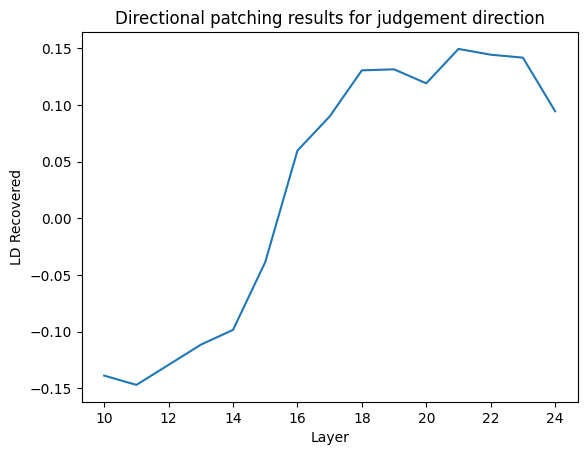

In [242]:
plt.plot(range(10, 25), mean_patching_results)
plt.title("Directional patching results for judgement direction")
plt.xlabel("Layer")
plt.ylabel("LD Recovered")
plt.show()


# Steering